In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
import omnivida_loader as ov
import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Let's start by loading the cleansed datasets into pandas DataFrames. 

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
life_quality = ov.get_wellbeing_index_dataset()

### Life quality records

In [3]:
life_quality.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
life_quality.head(20)

,id_patient,creation_date,dimension,score
0,1645342,2016-09-27,Entorno,75.0
1,1645342,2016-09-27,Psicologico,81.0
2,1645342,2016-09-27,Relaciones interpersonales,100.0
3,1645342,2016-09-27,Salud fisica,25.0
4,1645342,2017-12-21,Entorno,63.0


In [4]:
life_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_patient     1012 non-null   int64         
 1   creation_date  1012 non-null   datetime64[ns]
 2   dimension      1012 non-null   category      
 3   score          1012 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 25.0 KB


In [5]:
life_quality.describe(include='all')

,id_patient,creation_date,dimension,score
count,1.012000e+03,1012,1012,1012.000000
unique,NaN,175,4,NaN
top,NaN,2017-03-06 00:00:00,Salud fisica,NaN
freq,NaN,32,253,NaN
first,NaN,2014-11-04 00:00:00,NaN,NaN
last,NaN,2019-02-21 00:00:00,NaN,NaN
mean,1.255842e+06,NaN,NaN,67.318182
std,4.076585e+05,NaN,NaN,18.585210
min,5.029890e+05,NaN,NaN,6.000000
25%,9.165100e+05,NaN,NaN,56.000000


,id_patient,count
0,739693,9
1,1617372,8
2,1427481,7
3,1690591,6
4,1764814,6


253


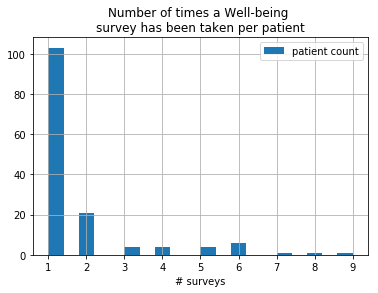

In [6]:
num_surveys_per_patient = life_quality[life_quality['dimension']=='Entorno'].groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count')
display(num_surveys_per_patient.head())
print(sum(num_surveys_per_patient['count']))
num_surveys_per_patient.hist('count', bins=20)
plt.xlabel('# surveys')
plt.title('Number of times a Well-being \nsurvey has been taken per patient')
plt.legend(['patient count'])

In [7]:
num_surveys_per_patient[num_surveys_per_patient['count']==1]

,id_patient,count
42,1121922,1
43,1059652,1
44,1059543,1
45,972824,1
46,1063469,1
...,...,...
140,1460766,1
141,1479905,1
142,1491934,1
143,1495562,1


In [8]:
pivoted_life_quality = pd.DataFrame()
for patient, df in life_quality.groupby('id_patient'):
    pvt = df.pivot(index='creation_date', columns='dimension', values='score')
    pvt.columns = pvt.columns.categories
    pvt.reset_index(inplace=True)
    pvt['id_patient'] = patient
    cols = [list(pvt.columns)[-1]] + list(pvt.columns)[:-1]
    pvt = pvt[cols]
    pivoted_life_quality = pivoted_life_quality.append(pvt, ignore_index=True)
#     display(pivoted_life_quality)

pivoted_life_quality

,id_patient,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
0,502989,2017-01-03,63.0,69.0,50.0,63.0
1,524006,2015-09-10,56.0,69.0,44.0,44.0
2,524006,2015-11-18,100.0,94.0,75.0,94.0
3,524006,2016-03-18,100.0,94.0,94.0,100.0
4,524006,2016-08-08,100.0,94.0,94.0,100.0
...,...,...,...,...,...,...
248,1962088,2016-12-20,63.0,69.0,69.0,31.0
249,1978721,2015-06-02,63.0,81.0,56.0,63.0
250,1978721,2015-09-14,69.0,75.0,56.0,63.0
251,1991750,2017-01-13,81.0,69.0,69.0,63.0


In [9]:
adherence.head()

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
0,500547,2016-07-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
1,500547,2019-03-14,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
2,500547,2019-10-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
3,500547,2019-12-09,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
4,500547,2020-01-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A


In [10]:
adherence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4765 entries, 0 to 4764
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_patient           4765 non-null   int64         
 1   survey_date          4765 non-null   datetime64[ns]
 2   morisky_green        4765 non-null   float64       
 3   smaq1                4765 non-null   float64       
 4   smaq2                4765 non-null   float64       
 5   espa                 4765 non-null   float64       
 6   nm_espa              4765 non-null   float64       
 7   qualitative_result   4765 non-null   float64       
 8   quantitative_result  4765 non-null   float64       
 9   category             4765 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(7), int64(1)
memory usage: 340.0 KB


In [11]:
adherence.describe(include='all')

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
count,4.765000e+03,4765,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765
unique,NaN,1433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,2019-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2319
first,NaN,2012-04-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.238039e+06,NaN,0.849528,0.836726,3.774816,0.830220,5.603148,0.793494,3.774816,NaN
std,4.295039e+05,NaN,0.357571,0.369654,0.798742,0.375478,0.912014,0.404840,0.798742,NaN
min,5.005470e+05,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,8.716330e+05,NaN,1.000000,1.000000,4.000000,1.000000,5.000000,1.000000,4.000000,NaN


,id_patient,count_records
0,1769865,41
1,979605,30
2,1132214,28
3,1676414,26
4,622031,26
5,1196034,25
6,916510,24
7,1828862,23
8,1536265,23
9,1399081,23


4765


Text(0.5,1,'Number of adherence records per patient')

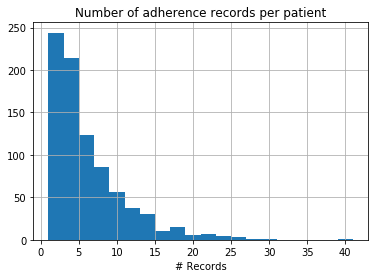

In [12]:
num_records_per_patient = adherence.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_patient.head(10))
print(sum(num_records_per_patient['count_records']))
num_records_per_patient.hist('count_records', bins=20)
plt.xlabel('# Records')
plt.title('Number of adherence records per patient')

,category,count_records
0,A,2319
1,M,1251
2,A-,689
3,N+,496
4,N,10


4765


Text(0.5,1,'Number records per category')

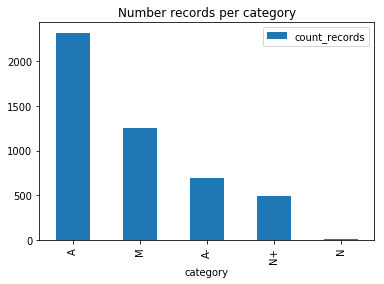

In [13]:
num_records_per_category = adherence.groupby('category').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_category)
print(sum(num_records_per_category['count_records']))
num_records_per_category.plot(kind='bar', x='category')
# plt.xlabel('# Records')
plt.title('Number records per category')

In [14]:
adherence_change.head(10)

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category,morisky_change,smaq1_change,smaq2_change,espa_change,nm_espa_change,qualitative_result_change,quantitative_result_change,days_since_last_control,num_reports,ongoing_adherence_percentage
0,500547,2016-07-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
1,500547,2019-03-14,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,2,100.0
2,500547,2019-10-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0,3,100.0
3,500547,2019-12-09,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,4,100.0
4,500547,2020-01-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,5,100.0
5,500547,2020-03-25,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,6,100.0
6,500547,2020-05-08,1.0,1.0,4.0,1.0,5.0,1.0,4.0,A,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,44.0,7,100.0
7,500588,2019-04-26,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
8,502989,2014-08-22,0.0,0.0,2.0,1.0,5.0,0.0,2.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
9,502989,2014-10-28,0.0,0.0,2.0,0.0,5.0,0.0,2.0,M,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,67.0,2,0.0


In [15]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'quantitative_result', 'qualitative_result_change', 'quantitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.000000
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.000000
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.000000
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.000000
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.000000
5,500547,2020-03-25,A,1.0,4.0,0.0,0.0,69.0,100.000000
6,500547,2020-05-08,A,1.0,4.0,0.0,0.0,44.0,100.000000
7,500588,2019-04-26,A,1.0,4.0,NaN,NaN,NaN,100.000000
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000


In [16]:
adherence_change_analysis_pivot = adherence_change_analysis.copy()
adherence_change_analysis_pivot['survey_month'] = adherence_change_analysis_pivot['survey_date'].dt.month
adherence_change_analysis_pivot['survey_year'] = adherence_change_analysis_pivot['survey_date'].dt.year
adherence_pivot_dias_control = pd.pivot_table(adherence_change_analysis_pivot, values='days_since_last_control', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_adher_percentage = pd.pivot_table(adherence_change_analysis_pivot, values='ongoing_adherence_percentage', index='survey_month', columns='survey_year', aggfunc='mean')

Text(0.5,1,'Dias desde el ultimo control')

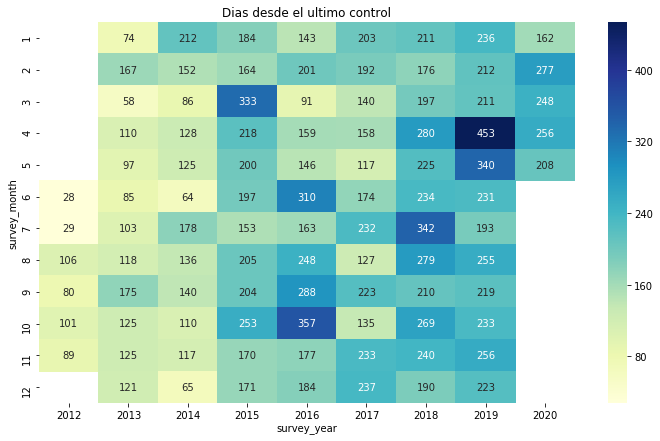

In [17]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_dias_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Dias desde el ultimo control')

Text(0.5,1,'Porcentage de adherencia historico promedio por mes')

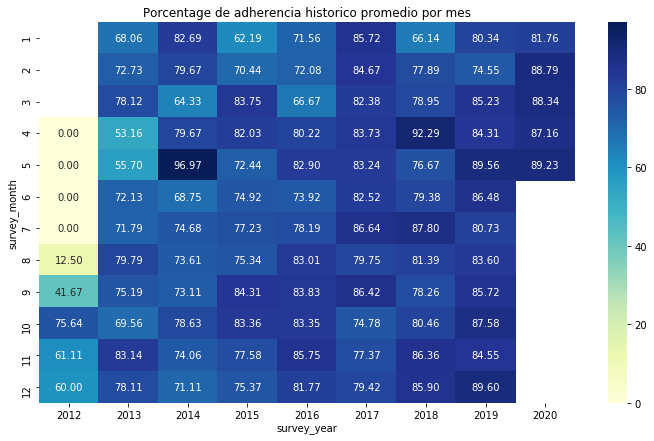

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_adher_percentage, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Porcentage de adherencia historico promedio por mes')

#### Let's have a look at those patients that went from `adherent` (i.e. 1 in the `cualitativo_ponderado` field) to `non-adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [19]:
neg_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==-1]
neg_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
14,502989,2016-01-12,M,0.0,3.0,-1.0,-1.0,201.0,14.285714
16,502989,2017-01-03,M,0.0,3.0,-1.0,-1.0,354.0,22.222222
20,502989,2018-10-03,M,0.0,4.0,-1.0,0.0,421.0,38.461538
35,506808,2018-10-08,M,0.0,4.0,-1.0,0.0,131.0,85.714286
44,512938,2018-05-04,M,0.0,4.0,-1.0,0.0,216.0,85.714286
48,512938,2019-09-30,M,0.0,1.0,-1.0,-3.0,293.0,72.727273
51,514102,2018-01-30,A,0.0,4.0,-1.0,0.0,74.0,66.666667
55,524006,2015-10-13,A-,0.0,4.0,-1.0,0.0,33.0,66.666667
62,524006,2017-05-10,A-,0.0,3.0,-1.0,-1.0,28.0,70.000000
93,529410,2018-01-30,A-,0.0,4.0,-1.0,0.0,122.0,66.666667


In [20]:
neg_transition_count = neg_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count')

In [21]:
for patient, df in adherence_change_analysis.groupby('id_patient'):
    if df.shape[0] == 1 or (df.qualitative_result_change[1:] > -1).all():
        neg_transition_count = neg_transition_count.append({
            'id_patient': patient,
            'count': 0
        }, ignore_index=True)
        
neg_transition_count

,id_patient,count
0,1769865,7
1,832593,7
2,622031,6
3,739693,6
4,673765,6
...,...,...
835,1980742,0
836,1988890,0
837,1995612,0
838,1999536,0


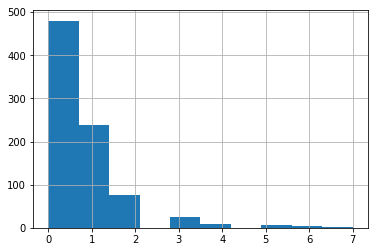

In [22]:
neg_transition_count['count'].hist()

Text(0.5,1,'Number of negative transitions per month')

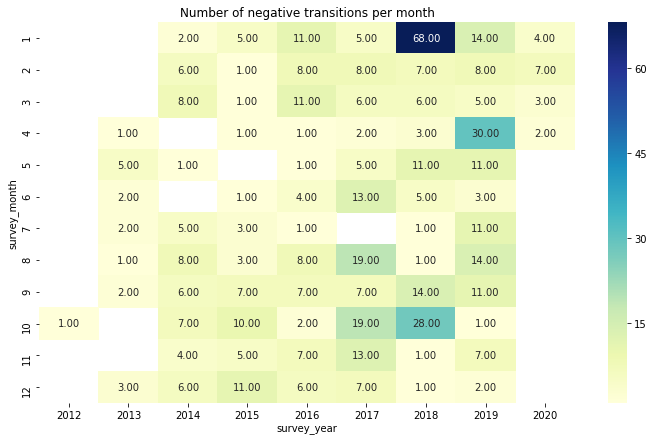

In [23]:
neg_transition_pivot = neg_transition.copy()
neg_transition_pivot['survey_month'] = neg_transition_pivot['survey_date'].dt.month
neg_transition_pivot['survey_year'] = neg_transition_pivot['survey_date'].dt.year
neg_transition_pivot = pd.pivot_table(neg_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(neg_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of negative transitions per month')

#### Let's have a look at those patients that went from `non-adherent` (i.e. 0 in the `cualitativo_ponderado` field) to `adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [24]:
pos_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==1]
pos_transition

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
13,502989,2015-06-25,M,1.0,4.0,1.0,1.0,162.0,16.666667
15,502989,2016-01-15,M,1.0,4.0,1.0,1.0,3.0,25.000000
17,502989,2017-03-21,M,1.0,4.0,1.0,1.0,77.0,30.000000
21,502989,2019-02-08,M,1.0,4.0,1.0,0.0,128.0,42.857143
23,506808,2013-05-24,M,1.0,4.0,1.0,0.0,16.0,50.000000
...,...,...,...,...,...,...,...,...,...
4738,1997065,2016-01-22,M,1.0,4.0,1.0,0.0,44.0,87.500000
4740,1997065,2017-03-13,M,1.0,4.0,1.0,4.0,277.0,80.000000
4747,1997825,2020-01-16,M,1.0,4.0,1.0,1.0,168.0,66.666667
4753,1998401,2014-10-03,A-,1.0,4.0,1.0,1.0,212.0,83.333333


In [25]:
pos_transition_count = pos_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count')

In [26]:
for patient, df in adherence_change_analysis.groupby('id_patient'):
    if df.shape[0] == 1 or (df.qualitative_result_change[1:] < 1).all():
        pos_transition_count = pos_transition_count.append({
            'id_patient': patient,
            'count': 0
        }, ignore_index=True)

pos_transition_count

,id_patient,count
0,1769865,8
1,622031,7
2,832593,7
3,1132214,6
4,673765,6
...,...,...
835,1988890,0
836,1994641,0
837,1995612,0
838,1999536,0


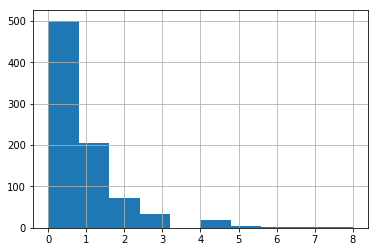

In [27]:
pos_transition_count['count'].hist()

Text(0.5,1,'Number of positive transitions per month')

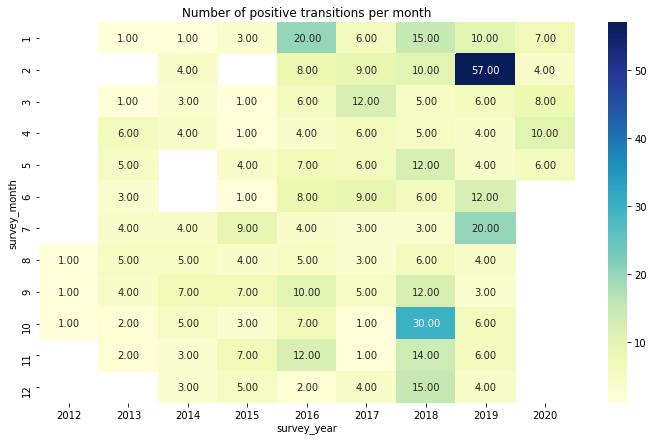

In [28]:
pos_transition_pivot = pos_transition.copy()
pos_transition_pivot['survey_month'] = pos_transition_pivot['survey_date'].dt.month
pos_transition_pivot['survey_year'] = pos_transition_pivot['survey_date'].dt.year
pos_transition_pivot = pd.pivot_table(pos_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(pos_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of positive transitions per month')

#### Let's try to match the adherence survey records with the life quality survey results 

In [29]:
surveyed_patients_lq = pivoted_life_quality.id_patient.unique()
adher_columns = ['id_patient', 'survey_date', 'num_reports', 'qualitative_result', 'qualitative_result_change', 
                 'quantitative_result', 'quantitative_result_change', 'days_since_last_control', 
                 'ongoing_adherence_percentage', 'category']
adherence_change_lq = adherence_change[adher_columns][adherence_change['id_patient'].isin(surveyed_patients_lq)]
adherence_change_no_lq = adherence_change[adher_columns][~adherence_change['id_patient'].isin(surveyed_patients_lq)]
display(adherence_change_lq)
display(adherence_change_no_lq)

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category
8,502989,2014-08-22,1,0.0,NaN,2.0,NaN,NaN,0.000000,M
9,502989,2014-10-28,2,0.0,0.0,2.0,0.0,67.0,0.000000,M
10,502989,2014-11-21,3,0.0,0.0,4.0,2.0,24.0,0.000000,M
11,502989,2015-01-07,4,0.0,0.0,3.0,-1.0,47.0,0.000000,M
12,502989,2015-01-14,5,0.0,0.0,3.0,0.0,7.0,0.000000,M
...,...,...,...,...,...,...,...,...,...,...
4740,1997065,2017-03-13,10,1.0,1.0,4.0,4.0,277.0,80.000000,M
4741,1997065,2017-05-23,11,1.0,0.0,4.0,0.0,71.0,81.818182,M
4742,1997065,2018-02-23,12,1.0,0.0,4.0,0.0,276.0,83.333333,M
4743,1997065,2018-10-09,13,1.0,0.0,4.0,0.0,228.0,84.615385,M


,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category
0,500547,2016-07-11,1,1.0,NaN,4.0,NaN,NaN,100.0,A
1,500547,2019-03-14,2,1.0,0.0,4.0,0.0,976.0,100.0,A
2,500547,2019-10-11,3,1.0,0.0,4.0,0.0,211.0,100.0,A
3,500547,2019-12-09,4,1.0,0.0,4.0,0.0,59.0,100.0,A
4,500547,2020-01-16,5,1.0,0.0,4.0,0.0,38.0,100.0,A
...,...,...,...,...,...,...,...,...,...,...
4760,1999536,2018-08-08,1,1.0,NaN,4.0,NaN,NaN,100.0,A
4761,1999536,2020-02-22,2,1.0,0.0,4.0,0.0,563.0,100.0,A
4762,1999629,2018-04-06,1,1.0,NaN,4.0,NaN,NaN,100.0,A
4763,1999629,2018-05-04,2,1.0,0.0,4.0,0.0,28.0,100.0,A


In [30]:
# def find_closest_date(df1_row, date_field_d1, df2, date_field_df2, filter_on='id_patient', add_time_delta_column=True):
#     deltas = np.abs(df2[df2[filter_on]==df1_row[filter_on]][date_field_df2] - df1_row[date_field_d1]).reset_index(drop=True)
#     #print(f"\n\nADHERENCE ROW: \n{df1_row}")
#     #print(f"\nDELTAS: \n{deltas}")
#     idx_closest_date = np.argmin(deltas)
#     #print(f"\nCLOSEST VALUE: \n{df2[df2[filter_on]==df1_row[filter_on]].iloc[idx_closest_date]}")
#     closest_date = df2[df2[filter_on]==df1_row[filter_on]].iloc[idx_closest_date][date_field_df2]
#     res = {"closest_date": closest_date}
#     idx = ['closest_date']
#     if add_time_delta_column:
#         res["closest_delta"] = (deltas[idx_closest_date] / np.timedelta64(1, 'D')) * (-1.0 if closest_date > df1_row[date_field_d1] else 1.0)
#         idx.append('closest_delta')
#     return pd.Series(res, index=idx)

# def merge_on_closest_date(df1, df2, date_field_d1, date_field_df2, merge_on='id_patient'):
#     temp_df1 = df1.copy()
#     temp_df1[[f'closest_{date_field_df2}', f'days_since_{date_field_df2}']] = temp_df1.apply(
#                                           find_closest_date, args=[date_field_d1, df2, date_field_df2, merge_on], axis=1)
    
#     result_df = pd.merge(temp_df1, df2, left_on=[merge_on, f'closest_{date_field_df2}'], right_on=[merge_on, date_field_df2])
#     return result_df.drop(columns=f'closest_{date_field_df2}', axis=1)

In [31]:
# def find_closest_date(adherence_row, lq_surveys, add_time_delta_column=True):
#     # takes a pd.Timestamp() instance and a pd.Series with dates in it
#     # calcs the delta between `timepoint` and each date in `time_series`
#     # returns the closest date and optionally the number of days in its time delta
#     deltas = np.abs(lq_surveys[lq_surveys['id_patient']==adherence_row['id_patient']].creation_date - adherence_row['survey_date']).reset_index(drop=True)
#     #print(f"\n\nADHERENCE ROW: \n{adherence_row}")
#     #print(f"\nDELTAS: \n{deltas}")
#     idx_closest_date = np.argmin(deltas)
#     #print(f"\nCLOSEST VALUE: \n{lq_surveys[lq_surveys['id_patient']==adherence_row['id_patient']].iloc[idx_closest_date]}")
#     closest_date = lq_surveys[lq_surveys['id_patient']==adherence_row['id_patient']].iloc[idx_closest_date]["creation_date"]
#     res = {"closest_date": closest_date}
#     idx = ['closest_date']
#     if add_time_delta_column:
#         res["closest_delta"] = (deltas[idx_closest_date] / np.timedelta64(1, 'D')) * (-1.0 if closest_date > adherence_row['survey_date'] else 1.0)
#         idx.append('closest_delta')
#     return pd.Series(res, index=idx)

# adherence_change_lq[['closest_well_being_survey', 'days_since_last_well_being_survey']] = adherence_change_lq.apply(
#                                           find_closest_date, args=[pivoted_life_quality], axis=1)
# adherence_change_lq

In [32]:
# adherence_change_life_quality = pd.merge(adherence_change_lq, pivoted_life_quality, left_on=['id_patient','closest_well_being_survey'], right_on=['id_patient','creation_date'])
adherence_change_life_quality = ovu.merge_on_closest_date(df1=adherence_change_lq, df2=pivoted_life_quality, date_field_df1='survey_date', date_field_df2='creation_date', merge_on='id_patient')

In [33]:
adherence_change_life_quality.rename(columns={'days_since_creation_date': 'days_since_last_well_being_survey'}, inplace=True)
adherence_change_life_quality

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
0,502989,2017-01-03,9,0.0,-1.0,3.0,-1.0,354.0,22.222222,M,0.0,2017-01-03,63.0,69.0,50.0,63.0
1,502989,2017-03-21,10,1.0,1.0,4.0,1.0,77.0,30.000000,M,77.0,2017-01-03,63.0,69.0,50.0,63.0
2,502989,2017-07-10,11,1.0,0.0,4.0,0.0,111.0,36.363636,M,188.0,2017-01-03,63.0,69.0,50.0,63.0
3,502989,2017-08-08,12,1.0,0.0,4.0,0.0,29.0,41.666667,M,217.0,2017-01-03,63.0,69.0,50.0,63.0
4,502989,2018-10-03,13,0.0,-1.0,4.0,0.0,421.0,38.461538,M,638.0,2017-01-03,63.0,69.0,50.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,1997065,2017-03-13,10,1.0,1.0,4.0,4.0,277.0,80.000000,M,0.0,2017-03-13,81.0,94.0,69.0,63.0
985,1997065,2017-05-23,11,1.0,0.0,4.0,0.0,71.0,81.818182,M,71.0,2017-03-13,81.0,94.0,69.0,63.0
986,1997065,2018-02-23,12,1.0,0.0,4.0,0.0,276.0,83.333333,M,347.0,2017-03-13,81.0,94.0,69.0,63.0
987,1997065,2018-10-09,13,1.0,0.0,4.0,0.0,228.0,84.615385,M,575.0,2017-03-13,81.0,94.0,69.0,63.0


In [34]:
corr_adherence_change_life_quality = adherence_change_life_quality.corr()

Text(0.5,1,'Correlation Matrix')

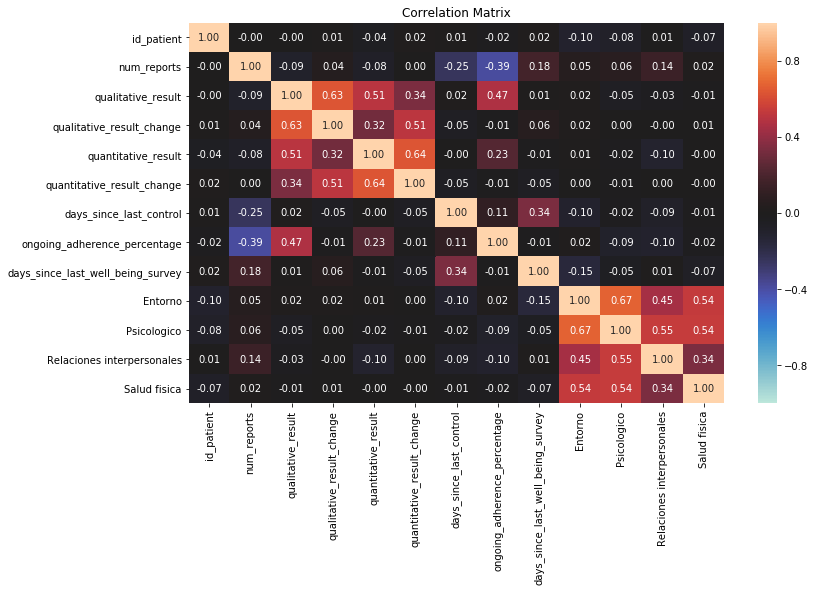

In [35]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_adherence_change_life_quality, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [36]:
adherence_change_life_quality.head(20)

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
0,502989,2017-01-03,9,0.0,-1.0,3.0,-1.0,354.0,22.222222,M,0.0,2017-01-03,63.0,69.0,50.0,63.0
1,502989,2017-03-21,10,1.0,1.0,4.0,1.0,77.0,30.000000,M,77.0,2017-01-03,63.0,69.0,50.0,63.0
2,502989,2017-07-10,11,1.0,0.0,4.0,0.0,111.0,36.363636,M,188.0,2017-01-03,63.0,69.0,50.0,63.0
3,502989,2017-08-08,12,1.0,0.0,4.0,0.0,29.0,41.666667,M,217.0,2017-01-03,63.0,69.0,50.0,63.0
4,502989,2018-10-03,13,0.0,-1.0,4.0,0.0,421.0,38.461538,M,638.0,2017-01-03,63.0,69.0,50.0,63.0
5,502989,2019-02-08,14,1.0,1.0,4.0,0.0,128.0,42.857143,M,766.0,2017-01-03,63.0,69.0,50.0,63.0
6,524006,2015-09-10,2,1.0,0.0,4.0,0.0,248.0,100.000000,A-,0.0,2015-09-10,56.0,69.0,44.0,44.0
7,524006,2015-10-13,3,0.0,-1.0,4.0,0.0,33.0,66.666667,A-,33.0,2015-09-10,56.0,69.0,44.0,44.0
8,524006,2015-11-09,4,0.0,0.0,4.0,0.0,27.0,50.000000,A-,60.0,2015-09-10,56.0,69.0,44.0,44.0
9,524006,2016-06-02,5,1.0,1.0,4.0,0.0,206.0,60.000000,A-,76.0,2016-03-18,100.0,94.0,94.0,100.0


In [37]:
adherence_change_life_quality[adherence_change_life_quality['id_patient']==524006]

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
6,524006,2015-09-10,2,1.0,0.0,4.0,0.0,248.0,100.000000,A-,0.0,2015-09-10,56.0,69.0,44.0,44.0
7,524006,2015-10-13,3,0.0,-1.0,4.0,0.0,33.0,66.666667,A-,33.0,2015-09-10,56.0,69.0,44.0,44.0
8,524006,2015-11-09,4,0.0,0.0,4.0,0.0,27.0,50.000000,A-,60.0,2015-09-10,56.0,69.0,44.0,44.0
9,524006,2016-06-02,5,1.0,1.0,4.0,0.0,206.0,60.000000,A-,76.0,2016-03-18,100.0,94.0,94.0,100.0
10,524006,2016-10-07,6,1.0,0.0,4.0,0.0,127.0,66.666667,A-,60.0,2016-08-08,100.0,94.0,94.0,100.0
11,524006,2016-11-08,7,1.0,0.0,4.0,0.0,32.0,71.428571,A-,92.0,2016-08-08,100.0,94.0,94.0,100.0
12,524006,2017-01-27,8,1.0,0.0,4.0,0.0,80.0,75.000000,A-,53.0,2016-12-05,88.0,81.0,69.0,69.0
13,524006,2017-04-12,9,1.0,0.0,4.0,0.0,75.0,77.777778,A-,128.0,2016-12-05,88.0,81.0,69.0,69.0
14,524006,2017-05-10,10,0.0,-1.0,3.0,-1.0,28.0,70.000000,A-,156.0,2016-12-05,88.0,81.0,69.0,69.0
15,524006,2017-07-28,11,1.0,1.0,4.0,1.0,79.0,72.727273,A-,235.0,2016-12-05,88.0,81.0,69.0,69.0


In [38]:
np.abs(adherence_change_life_quality[adherence_change_life_quality['id_patient']==524006].days_since_last_well_being_survey).min()

0.0

In [39]:
adherence_change_life_quality_filtered = pd.DataFrame()

for key, df in adherence_change_life_quality.groupby(['id_patient','creation_date']):
    temp_df = df[np.abs(df.days_since_last_well_being_survey) == np.abs(df.days_since_last_well_being_survey).min()].copy()
#     display(temp_df)
    adherence_change_life_quality_filtered = adherence_change_life_quality_filtered.append(temp_df, ignore_index=True)
    
adherence_change_life_quality_filtered.days_since_last_well_being_survey = np.abs(adherence_change_life_quality_filtered.days_since_last_well_being_survey)
adherence_change_life_quality_filtered

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
0,502989,2017-01-03,9,0.0,-1.0,3.0,-1.0,354.0,22.222222,M,0.0,2017-01-03,63.0,69.0,50.0,63.0
1,524006,2015-09-10,2,1.0,0.0,4.0,0.0,248.0,100.000000,A-,0.0,2015-09-10,56.0,69.0,44.0,44.0
2,524006,2016-06-02,5,1.0,1.0,4.0,0.0,206.0,60.000000,A-,76.0,2016-03-18,100.0,94.0,94.0,100.0
3,524006,2016-10-07,6,1.0,0.0,4.0,0.0,127.0,66.666667,A-,60.0,2016-08-08,100.0,94.0,94.0,100.0
4,524006,2017-01-27,8,1.0,0.0,4.0,0.0,80.0,75.000000,A-,53.0,2016-12-05,88.0,81.0,69.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,1962088,2017-01-07,1,1.0,NaN,4.0,NaN,NaN,100.000000,A,18.0,2016-12-20,63.0,69.0,69.0,31.0
230,1978721,2015-09-10,1,1.0,NaN,4.0,NaN,NaN,100.000000,M,100.0,2015-06-02,63.0,81.0,56.0,63.0
231,1978721,2015-10-05,2,1.0,0.0,4.0,0.0,25.0,100.000000,M,21.0,2015-09-14,69.0,75.0,56.0,63.0
232,1991750,2017-01-13,2,1.0,0.0,4.0,0.0,38.0,100.000000,A,0.0,2017-01-13,81.0,69.0,69.0,63.0


In [40]:
corr_adherence_change_life_quality_filtered = adherence_change_life_quality_filtered.corr()

Text(0.5,1,'Correlation Matrix')

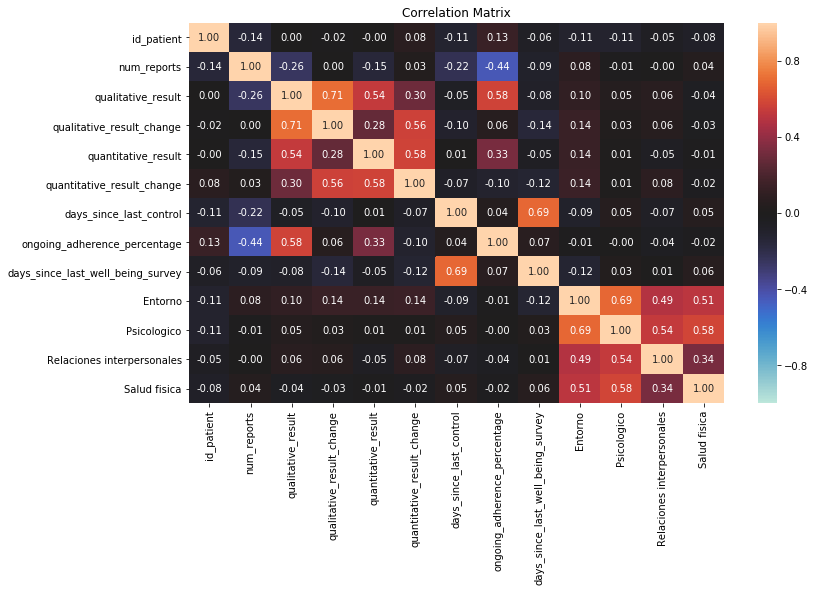

In [41]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_adherence_change_life_quality_filtered, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [42]:
adherence_change_life_quality_weighted = adherence_change_life_quality.copy()
sf = 10.

def get_timescaled_wb(row, dimension, sf):
    return row[dimension]*np.exp(-row['days_since_last_well_being_survey'] / sf) if row['days_since_last_well_being_survey'] >= 0 else 0.0

adherence_change_life_quality_weighted['Entorno'] = adherence_change_life_quality_weighted.apply(get_timescaled_wb, args=['Entorno', sf], axis=1)
adherence_change_life_quality_weighted['Psicologico'] = adherence_change_life_quality_weighted.apply(get_timescaled_wb, args=['Psicologico', sf], axis=1)
adherence_change_life_quality_weighted['Relaciones interpersonales'] = adherence_change_life_quality_weighted.apply(get_timescaled_wb, args=['Relaciones interpersonales', sf], axis=1)
adherence_change_life_quality_weighted['Salud fisica'] = adherence_change_life_quality_weighted.apply(get_timescaled_wb, args=['Salud fisica', sf], axis=1)
adherence_change_life_quality_weighted['wb_score'] = (adherence_change_life_quality_weighted['Entorno'] + adherence_change_life_quality_weighted['Psicologico'] + adherence_change_life_quality_weighted['Relaciones interpersonales'] + adherence_change_life_quality_weighted['Salud fisica']) / 4.

adherence_change_life_quality_weighted.head(20)

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica,wb_score
0,502989,2017-01-03,9,0.0,-1.0,3.0,-1.0,354.0,22.222222,M,0.0,2017-01-03,6.300000e+01,6.900000e+01,5.000000e+01,6.300000e+01,6.125000e+01
1,502989,2017-03-21,10,1.0,1.0,4.0,1.0,77.0,30.000000,M,77.0,2017-01-03,2.852811e-02,3.124508e-02,2.264136e-02,2.852811e-02,2.773566e-02
2,502989,2017-07-10,11,1.0,0.0,4.0,0.0,111.0,36.363636,M,188.0,2017-01-03,4.311261e-07,4.721857e-07,3.421636e-07,4.311261e-07,4.191504e-07
3,502989,2017-08-08,12,1.0,0.0,4.0,0.0,29.0,41.666667,M,217.0,2017-01-03,2.372194e-08,2.598118e-08,1.882694e-08,2.372194e-08,2.306300e-08
4,502989,2018-10-03,13,0.0,-1.0,4.0,0.0,421.0,38.461538,M,638.0,2017-01-03,1.234106e-26,1.351640e-26,9.794495e-27,1.234106e-26,1.199826e-26
5,502989,2019-02-08,14,1.0,1.0,4.0,0.0,128.0,42.857143,M,766.0,2017-01-03,3.407087e-32,3.731572e-32,2.704037e-32,3.407087e-32,3.312446e-32
6,524006,2015-09-10,2,1.0,0.0,4.0,0.0,248.0,100.000000,A-,0.0,2015-09-10,5.600000e+01,6.900000e+01,4.400000e+01,4.400000e+01,5.325000e+01
7,524006,2015-10-13,3,0.0,-1.0,4.0,0.0,33.0,66.666667,A-,33.0,2015-09-10,2.065457e+00,2.544939e+00,1.622859e+00,1.622859e+00,1.964029e+00
8,524006,2015-11-09,4,0.0,0.0,4.0,0.0,27.0,50.000000,A-,60.0,2015-09-10,1.388101e-01,1.710339e-01,1.090651e-01,1.090651e-01,1.319936e-01
9,524006,2016-06-02,5,1.0,1.0,4.0,0.0,206.0,60.000000,A-,76.0,2016-03-18,5.004514e-02,4.704243e-02,4.704243e-02,5.004514e-02,4.854379e-02


In [43]:
corr_adherence_change_life_quality_weighted = adherence_change_life_quality_weighted.corr()

Text(0.5,1,'Correlation Matrix')

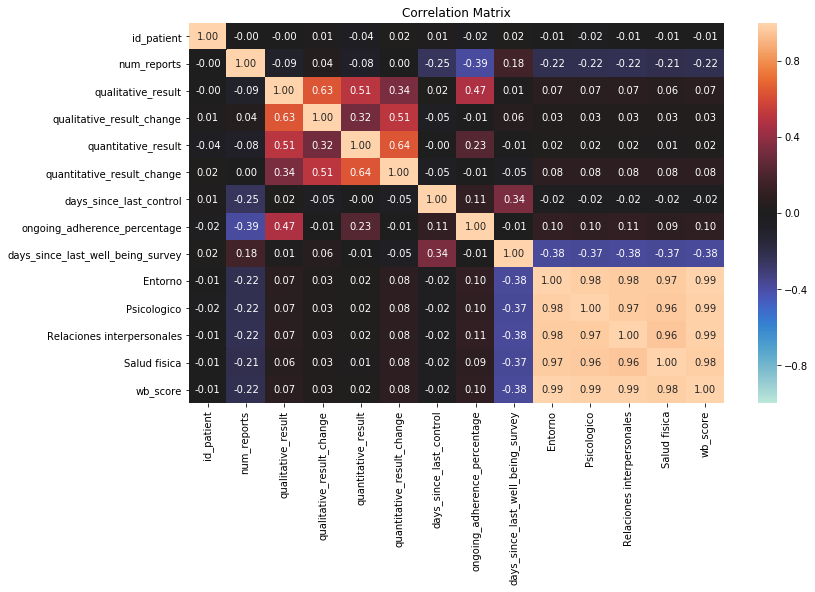

In [44]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_adherence_change_life_quality_weighted, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [45]:
adherence_change_life_quality_weighted[adherence_change_life_quality_weighted['id_patient']==524006]

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica,wb_score
6,524006,2015-09-10,2,1.0,0.0,4.0,0.0,248.0,100.000000,A-,0.0,2015-09-10,5.600000e+01,6.900000e+01,4.400000e+01,4.400000e+01,5.325000e+01
7,524006,2015-10-13,3,0.0,-1.0,4.0,0.0,33.0,66.666667,A-,33.0,2015-09-10,2.065457e+00,2.544939e+00,1.622859e+00,1.622859e+00,1.964029e+00
8,524006,2015-11-09,4,0.0,0.0,4.0,0.0,27.0,50.000000,A-,60.0,2015-09-10,1.388101e-01,1.710339e-01,1.090651e-01,1.090651e-01,1.319936e-01
9,524006,2016-06-02,5,1.0,1.0,4.0,0.0,206.0,60.000000,A-,76.0,2016-03-18,5.004514e-02,4.704243e-02,4.704243e-02,5.004514e-02,4.854379e-02
10,524006,2016-10-07,6,1.0,0.0,4.0,0.0,127.0,66.666667,A-,60.0,2016-08-08,2.478752e-01,2.330027e-01,2.330027e-01,2.478752e-01,2.404390e-01
11,524006,2016-11-08,7,1.0,0.0,4.0,0.0,32.0,71.428571,A-,92.0,2016-08-08,1.010394e-02,9.497704e-03,9.497704e-03,1.010394e-02,9.800822e-03
12,524006,2017-01-27,8,1.0,0.0,4.0,0.0,80.0,75.000000,A-,53.0,2016-12-05,4.392603e-01,4.043191e-01,3.444200e-01,3.444200e-01,3.831048e-01
13,524006,2017-04-12,9,1.0,0.0,4.0,0.0,75.0,77.777778,A-,128.0,2016-12-05,2.429480e-04,2.236226e-04,1.904933e-04,1.904933e-04,2.118893e-04
14,524006,2017-05-10,10,0.0,-1.0,3.0,-1.0,28.0,70.000000,A-,156.0,2016-12-05,1.477368e-05,1.359850e-05,1.158391e-05,1.158391e-05,1.288500e-05
15,524006,2017-07-28,11,1.0,1.0,4.0,1.0,79.0,72.727273,A-,235.0,2016-12-05,5.477247e-09,5.041557e-09,4.294660e-09,4.294660e-09,4.777031e-09


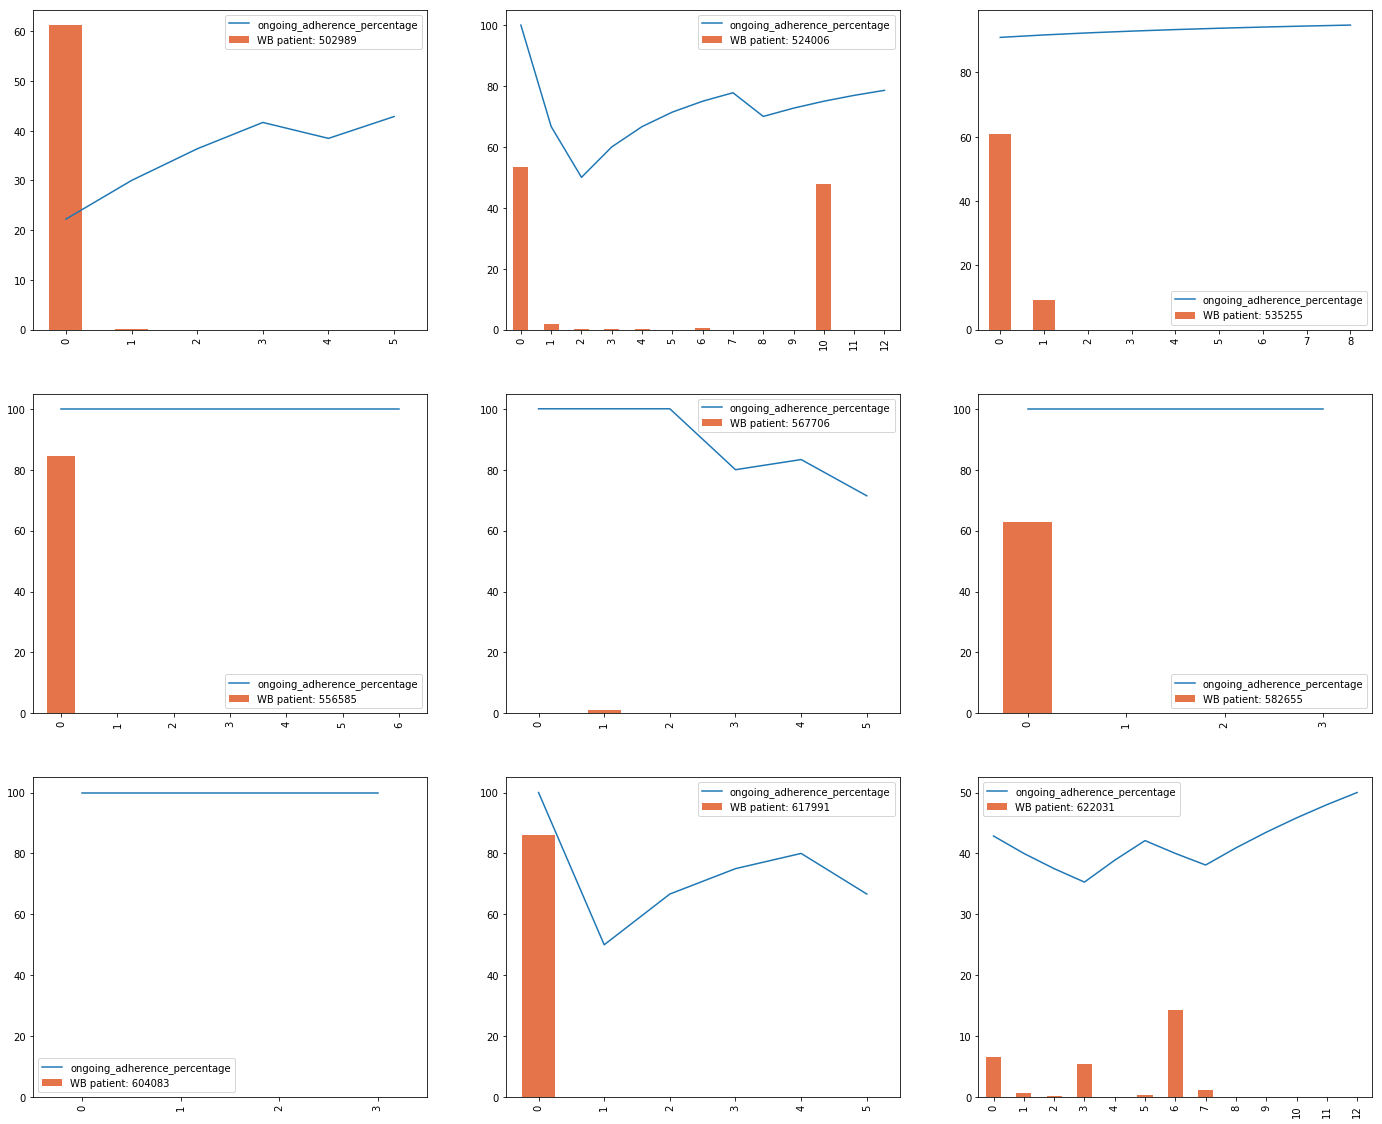

In [46]:
i = 0
n=9
vble1 = 'wb_score'
vble2 = 'ongoing_adherence_percentage'
plt.figure(figsize=(24,20))
for patient, df in adherence_change_life_quality_weighted.groupby('id_patient'):
    temp_df = df.copy().reset_index(drop=True)
    plt.subplot(np.ceil(np.sqrt(n)),np.ceil(np.sqrt(n)),i+1)
    temp_df[vble2].plot()
    temp_df[vble1].plot(kind='bar', label=f"WB patient: {patient}", color='#e6744a')
    plt.legend()
    i+=1
    if i>n-1:
        break

In [47]:
pivoted_life_quality[pivoted_life_quality['id_patient']==524006]

,id_patient,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
1,524006,2015-09-10,56.0,69.0,44.0,44.0
2,524006,2015-11-18,100.0,94.0,75.0,94.0
3,524006,2016-03-18,100.0,94.0,94.0,100.0
4,524006,2016-08-08,100.0,94.0,94.0,100.0
5,524006,2016-12-05,88.0,81.0,69.0,69.0
6,524006,2017-08-24,75.0,56.0,31.0,50.0


In [48]:
adherence_lq_tracing = pd.DataFrame()
adherence_no_lq_tracing = pd.DataFrame()
patients_with_timely_wb_tracing = [] 
patients_no_timely_wb_tracing = []
last_reported_adherence_percentage_lq_tracing = pd.DataFrame()
last_reported_adherence_percentage_no_lq_tracing = pd.DataFrame()
for patient, df in adherence_change_life_quality_weighted.groupby('id_patient'):
    temp_df = df.copy().reset_index(drop=True)
    last_alqt_dict = {
        'id_patient': patient,
        'ongoing_adherence_percentage': temp_df['ongoing_adherence_percentage'].iloc[-1],
        'last_wb_score': temp_df['wb_score'].iloc[-1]
    }
    if np.isclose(temp_df.wb_score, np.zeros(temp_df.shape[0])).all():
        adherence_no_lq_tracing = adherence_no_lq_tracing.append(temp_df, ignore_index=True)
        last_reported_adherence_percentage_no_lq_tracing = last_reported_adherence_percentage_no_lq_tracing.append(last_alqt_dict, ignore_index=True)
        patients_no_timely_wb_tracing.append(patient)
    else:
        adherence_lq_tracing = adherence_lq_tracing.append(temp_df, ignore_index=True)
        last_reported_adherence_percentage_lq_tracing = last_reported_adherence_percentage_lq_tracing.append(last_alqt_dict, ignore_index=True)
        patients_with_timely_wb_tracing.append(patient)

In [49]:
adherence_lq_tracing

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica,wb_score
0,502989,2017-01-03,9,0.0,-1.0,3.0,-1.0,354.0,22.222222,M,0.0,2017-01-03,6.300000e+01,6.900000e+01,5.000000e+01,6.300000e+01,6.125000e+01
1,502989,2017-03-21,10,1.0,1.0,4.0,1.0,77.0,30.000000,M,77.0,2017-01-03,2.852811e-02,3.124508e-02,2.264136e-02,2.852811e-02,2.773566e-02
2,502989,2017-07-10,11,1.0,0.0,4.0,0.0,111.0,36.363636,M,188.0,2017-01-03,4.311261e-07,4.721857e-07,3.421636e-07,4.311261e-07,4.191504e-07
3,502989,2017-08-08,12,1.0,0.0,4.0,0.0,29.0,41.666667,M,217.0,2017-01-03,2.372194e-08,2.598118e-08,1.882694e-08,2.372194e-08,2.306300e-08
4,502989,2018-10-03,13,0.0,-1.0,4.0,0.0,421.0,38.461538,M,638.0,2017-01-03,1.234106e-26,1.351640e-26,9.794495e-27,1.234106e-26,1.199826e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1997065,2017-03-13,10,1.0,1.0,4.0,4.0,277.0,80.000000,M,0.0,2017-03-13,8.100000e+01,9.400000e+01,6.900000e+01,6.300000e+01,7.675000e+01
940,1997065,2017-05-23,11,1.0,0.0,4.0,0.0,71.0,81.818182,M,71.0,2017-03-13,6.683350e-02,7.755986e-02,5.693224e-02,5.198161e-02,6.332680e-02
941,1997065,2018-02-23,12,1.0,0.0,4.0,0.0,276.0,83.333333,M,347.0,2017-03-13,6.893924e-14,8.000356e-14,5.872602e-14,5.361941e-14,6.532206e-14
942,1997065,2018-10-09,13,1.0,0.0,4.0,0.0,228.0,84.615385,M,575.0,2017-03-13,8.640767e-24,1.002756e-23,7.360654e-24,6.720597e-24,8.187394e-24


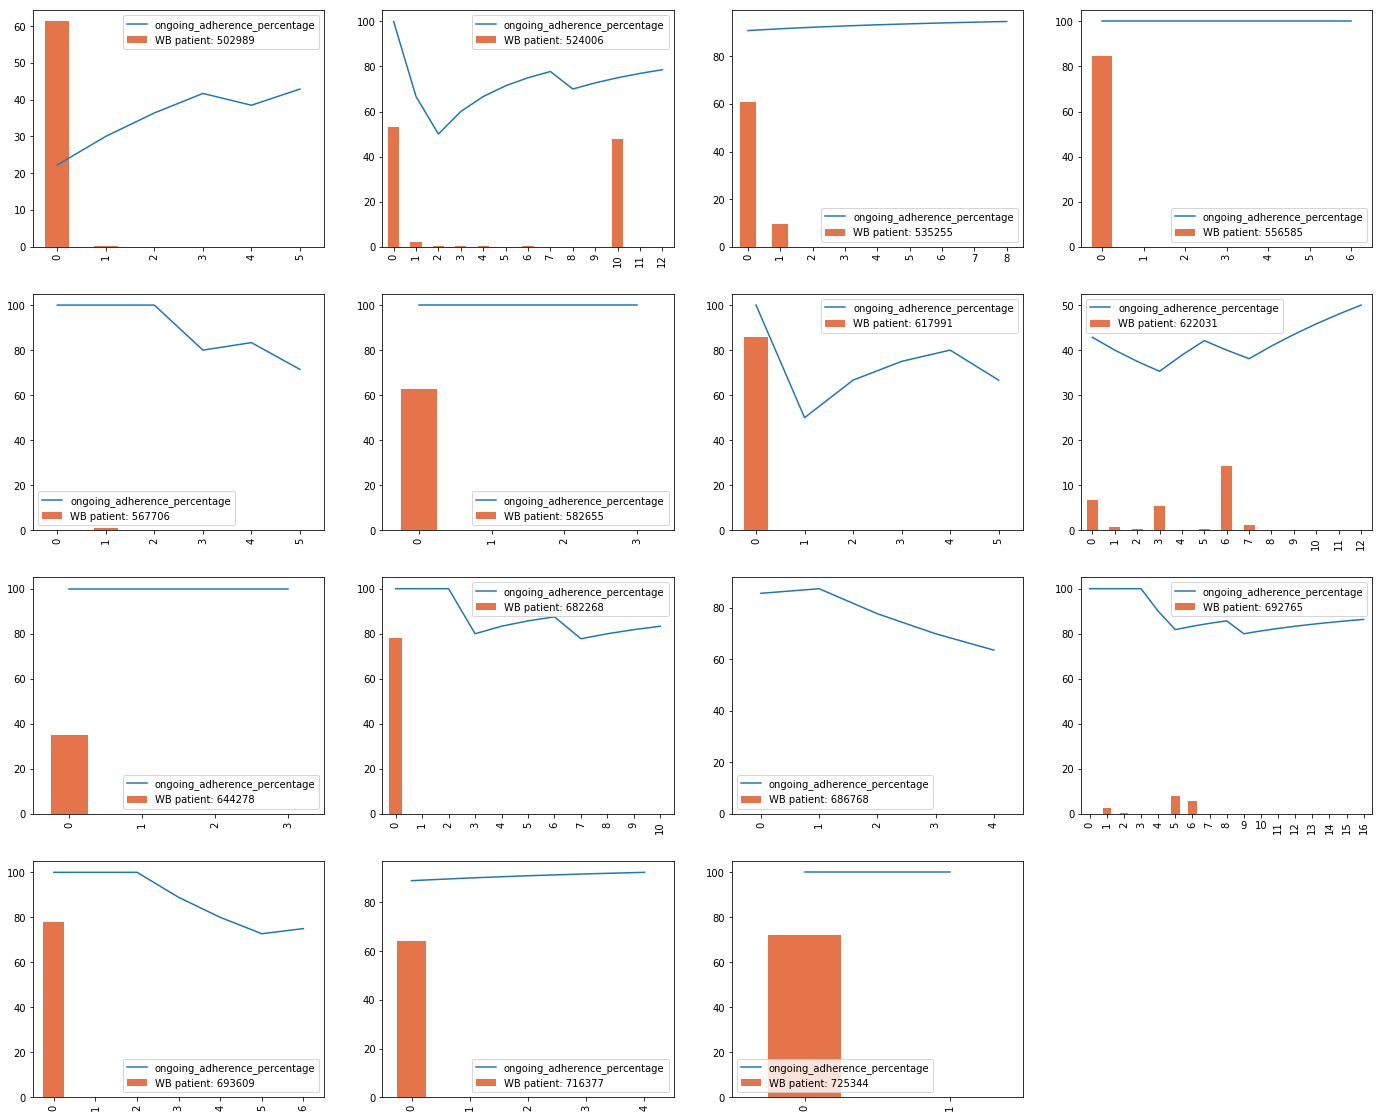

In [50]:
i = 0
n=15
vble1 = 'wb_score'
vble2 = 'ongoing_adherence_percentage'
plt.figure(figsize=(24,20))
for patient, df in adherence_lq_tracing.groupby('id_patient'):
    temp_df = df.copy().reset_index(drop=True)
    plt.subplot(np.ceil(np.sqrt(n)),np.ceil(np.sqrt(n)),i+1)
    temp_df[vble2].plot()
    temp_df[vble1].plot(kind='bar', label=f"WB patient: {patient}", color='#e6744a')
    plt.legend()
    i+=1
    if i>n-1:
        break

In [51]:
adherence_no_lq_tracing

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica,wb_score
0,604083,2018-12-19,3,1.0,0.0,4.0,0.0,1204.0,100.000000,A,1202.0,2015-09-04,3.138870e-51,3.138870e-51,3.138870e-51,2.385541e-51,2.950537e-51
1,604083,2019-02-08,4,1.0,0.0,4.0,0.0,51.0,100.000000,A,1253.0,2015-09-04,1.913689e-53,1.913689e-53,1.913689e-53,1.454404e-53,1.798868e-53
2,604083,2019-04-17,5,1.0,0.0,4.0,0.0,68.0,100.000000,A,1321.0,2015-09-04,2.131420e-56,2.131420e-56,2.131420e-56,1.619879e-56,2.003534e-56
3,604083,2019-12-24,6,1.0,0.0,4.0,0.0,251.0,100.000000,A,1572.0,2015-09-04,2.678412e-67,2.678412e-67,2.678412e-67,2.035593e-67,2.517708e-67
4,653834,2017-06-13,3,1.0,0.0,4.0,0.0,1216.0,100.000000,A,274.0,2016-09-12,1.020508e-10,1.020508e-10,9.449144e-11,1.020508e-10,1.001609e-10
5,653834,2017-07-14,4,1.0,0.0,4.0,0.0,31.0,100.000000,A,305.0,2016-09-12,4.597305e-12,4.597305e-12,4.256764e-12,4.597305e-12,4.512170e-12
6,653834,2018-01-25,5,0.0,-1.0,4.0,0.0,195.0,80.000000,A,500.0,2016-09-12,1.562287e-20,1.562287e-20,1.446562e-20,1.562287e-20,1.533356e-20
7,653834,2018-01-29,6,0.0,0.0,4.0,0.0,4.0,66.666667,A,504.0,2016-09-12,1.047233e-20,1.047233e-20,9.696598e-21,1.047233e-20,1.027839e-20
8,653834,2019-02-19,7,1.0,1.0,4.0,0.0,386.0,71.428571,A,890.0,2016-09-12,1.804164e-37,1.804164e-37,1.670523e-37,1.804164e-37,1.770754e-37
9,767551,2018-01-26,3,0.0,-1.0,4.0,0.0,282.0,66.666667,A,262.0,2017-05-09,3.137226e-10,2.635270e-10,2.091484e-10,2.886248e-10,2.687557e-10


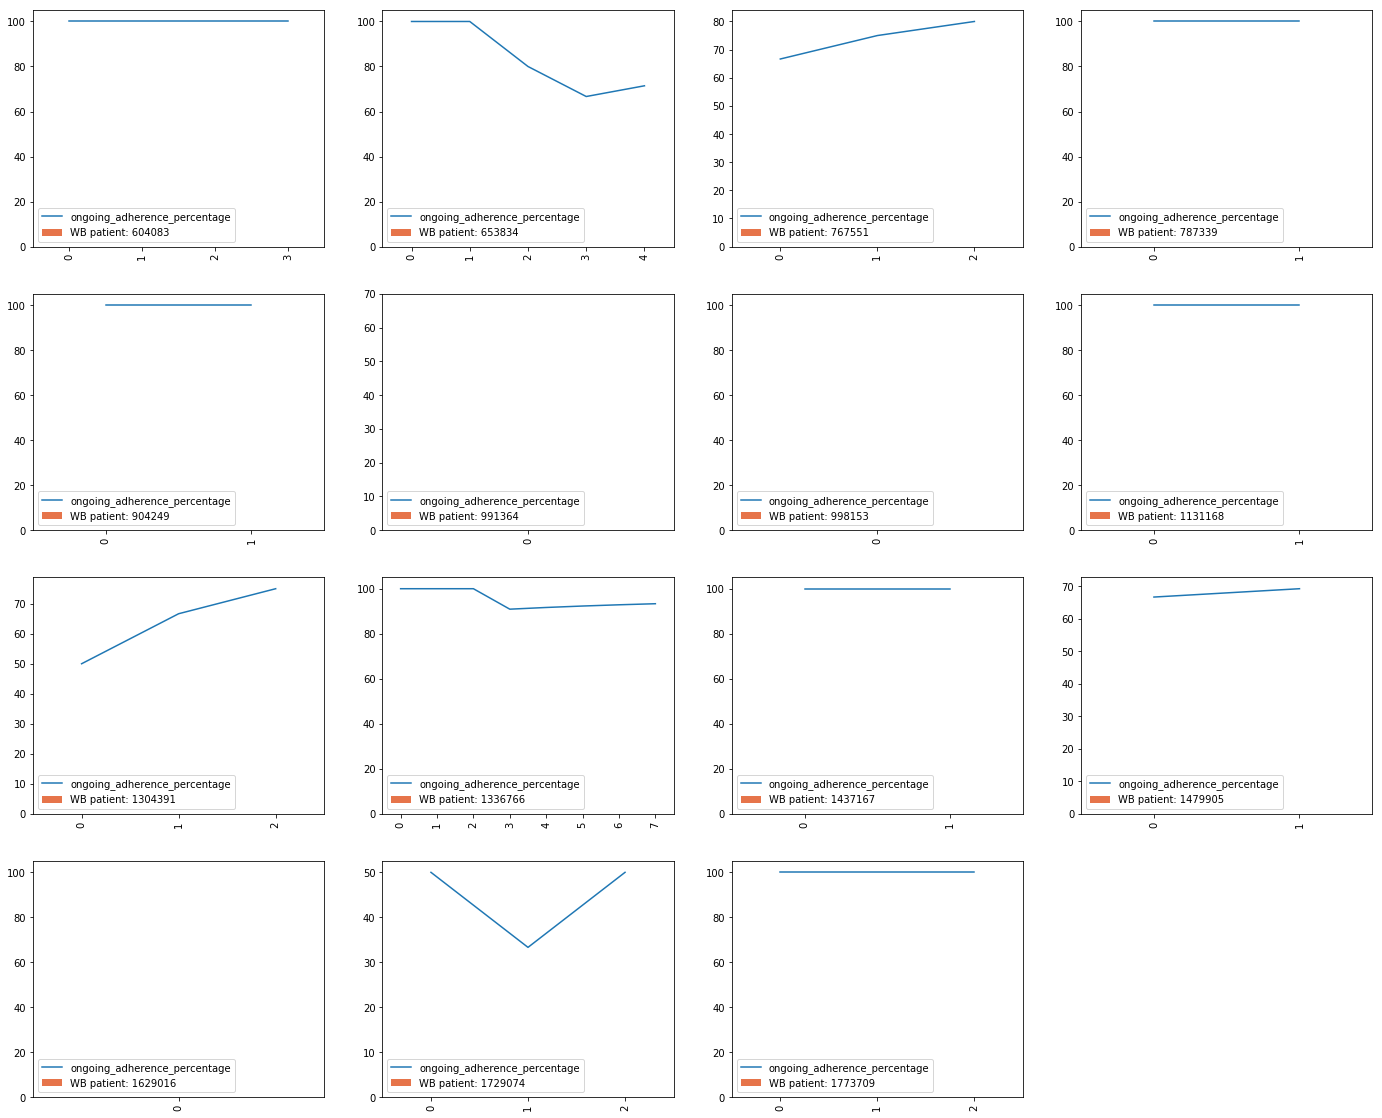

In [52]:
i = 0
n=15
vble1 = 'wb_score'
vble2 = 'ongoing_adherence_percentage'
plt.figure(figsize=(24,20))
for patient, df in adherence_no_lq_tracing.groupby('id_patient'):
    temp_df = df.copy().reset_index(drop=True)
    plt.subplot(np.ceil(np.sqrt(n)),np.ceil(np.sqrt(n)),i+1)
    temp_df[vble2].plot()
    temp_df[vble1].plot(kind='bar', label=f"WB patient: {patient}", color='#e6744a')
    plt.legend()
    i+=1
    if i>n-1:
        break

In [53]:
len(patients_with_timely_wb_tracing)

125

In [54]:
len(patients_no_timely_wb_tracing)

16

In [55]:
last_reported_adherence_percentage_lq_tracing['wb_tracing'] = 'timely'
last_reported_adherence_percentage_lq_tracing

,id_patient,last_wb_score,ongoing_adherence_percentage,wb_tracing
0,502989.0,3.312446e-32,42.857143,timely
1,524006.0,6.959373e-27,78.571429,timely
2,535255.0,1.424870e-46,94.736842,timely
3,556585.0,2.334763e-43,100.000000,timely
4,567706.0,5.971496e-53,71.428571,timely
...,...,...,...,...
120,1959667.0,5.762869e-52,75.000000,timely
121,1962088.0,6.651669e-52,100.000000,timely
122,1978721.0,3.812862e-59,87.500000,timely
123,1991750.0,2.588973e-37,80.000000,timely


In [56]:
last_reported_adherence_percentage_no_lq_tracing['wb_tracing'] = 'late'
last_reported_adherence_percentage_no_lq_tracing

,id_patient,last_wb_score,ongoing_adherence_percentage,wb_tracing
0,604083.0,2.517708e-67,100.000000,late
1,653834.0,1.770754e-37,71.428571,late
2,767551.0,5.955297e-47,80.000000,late
3,787339.0,3.094032e-34,100.000000,late
4,904249.0,2.183203e-48,100.000000,late
5,991364.0,6.208141e-33,66.666667,late
6,998153.0,6.747064e-38,100.000000,late
7,1131168.0,1.947614e-19,100.000000,late
8,1304391.0,9.016167e-39,75.000000,late
9,1336766.0,4.819766e-38,93.333333,late


In [57]:
last_reported_adherence_percentage_lq = pd.concat([last_reported_adherence_percentage_lq_tracing, last_reported_adherence_percentage_no_lq_tracing], ignore_index=True)
last_reported_adherence_percentage_lq.wb_tracing = last_reported_adherence_percentage_lq.wb_tracing.astype('category')

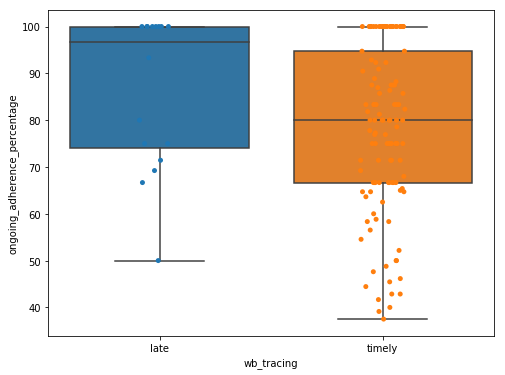

In [58]:
plt.figure(figsize=(8,6))
sns.stripplot(data=last_reported_adherence_percentage_lq, x='wb_tracing', y='ongoing_adherence_percentage')
sns.boxplot(data=last_reported_adherence_percentage_lq, x='wb_tracing', y='ongoing_adherence_percentage')

In [59]:
print(f"Average ongoing adherence for patients with timely well being tracing: {round(last_reported_adherence_percentage_lq_tracing.ongoing_adherence_percentage.mean(), 2)}")
print(f"Average ongoing adherence for patients without timely well being tracing: {round(last_reported_adherence_percentage_no_lq_tracing.ongoing_adherence_percentage.mean(), 2)}")

Average ongoing adherence for patients with timely well being tracing: 78.57
Average ongoing adherence for patients without timely well being tracing: 86.29


In [60]:
from scipy import stats

statistic, pvalue = stats.ttest_ind(last_reported_adherence_percentage_lq_tracing.ongoing_adherence_percentage, last_reported_adherence_percentage_no_lq_tracing.ongoing_adherence_percentage, equal_var=False, nan_policy='omit')
statistic, pvalue

(-1.7515736663126518, 0.09540809163858736)

In [61]:
adherence.shape

(4765, 10)

In [62]:
pivoted_life_quality.shape

(253, 6)

#### Setting an interval of 30 days prior to the occurence of the adherence survey 

In [63]:
adherence_change_life_quality.shape

(989, 16)

In [64]:
period = 30
aclq_timely = adherence_change_life_quality[adherence_change_life_quality.days_since_last_well_being_survey <= period]
aclq_late = adherence_change_life_quality[adherence_change_life_quality.days_since_last_well_being_survey > period]
aclq_timely

,id_patient,survey_date,num_reports,qualitative_result,qualitative_result_change,quantitative_result,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,category,days_since_last_well_being_survey,creation_date,Entorno,Psicologico,Relaciones interpersonales,Salud fisica
0,502989,2017-01-03,9,0.0,-1.0,3.0,-1.0,354.0,22.222222,M,0.0,2017-01-03,63.0,69.0,50.0,63.0
6,524006,2015-09-10,2,1.0,0.0,4.0,0.0,248.0,100.000000,A-,0.0,2015-09-10,56.0,69.0,44.0,44.0
16,524006,2017-08-25,12,1.0,0.0,4.0,0.0,28.0,75.000000,A-,1.0,2017-08-24,75.0,56.0,31.0,50.0
19,535255,2016-12-29,11,1.0,0.0,4.0,0.0,37.0,90.909091,A,0.0,2016-12-29,69.0,75.0,56.0,44.0
20,535255,2017-04-18,12,1.0,0.0,4.0,0.0,110.0,91.666667,A,19.0,2017-03-30,75.0,50.0,69.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,1941829,2017-03-24,3,1.0,0.0,4.0,0.0,1.0,100.000000,A,18.0,2017-03-06,69.0,81.0,69.0,81.0
970,1962088,2017-01-07,1,1.0,NaN,4.0,NaN,NaN,100.000000,A,18.0,2016-12-20,63.0,69.0,69.0,31.0
973,1978721,2015-10-05,2,1.0,0.0,4.0,0.0,25.0,100.000000,M,21.0,2015-09-14,69.0,75.0,56.0,63.0
980,1991750,2017-01-13,2,1.0,0.0,4.0,0.0,38.0,100.000000,A,0.0,2017-01-13,81.0,69.0,69.0,63.0


In [65]:
prob_df_data = []

pat, pnt, pt = ovu.compute_transition_probabilities(aclq_timely)
print(f'Patients with at least one well-being survey taken {period} days prior to the adherence survey: ')
print(f'\nProbability of a patient going from Non-adherent to Adherent: {round(pat, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt, 2)}')

prob_df_data.append([round(pat, 2), round(pnt, 2), round(pt, 2)])

Patients with at least one well-being survey taken 30 days prior to the adherence survey: 

Probability of a patient going from Non-adherent to Adherent: 0.77
Probability of a patient staying non-adherent: 0.23

Probability of a patient going from Adherent to Non-adherent: 0.18
Probability of a patient staying Adherent: 0.82

Probability of a patient transitioning (NA -> A or A -> NA): 0.31
Probability of a patient remaining unchaged: 0.69


In [66]:
pat, pnt, pt = ovu.compute_transition_probabilities(aclq_late)
print('Patients with late well-being monitoring (last well-being survey taken more \nthan 30 days before the adherence report): ')
print(f'\nProbability of a patient going from Non-adherent to Adherent: {round(pat, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt, 2)}')

prob_df_data.append([round(pat, 2), round(pnt, 2), round(pt, 2)])

Patients with late well-being monitoring (last well-being survey taken more 
than 30 days before the adherence report): 

Probability of a patient going from Non-adherent to Adherent: 0.58
Probability of a patient staying non-adherent: 0.42

Probability of a patient going from Adherent to Non-adherent: 0.2
Probability of a patient staying Adherent: 0.8

Probability of a patient transitioning (NA -> A or A -> NA): 0.3
Probability of a patient remaining unchaged: 0.7


In [67]:
pat, pnt, pt = ovu.compute_transition_probabilities(adherence_change_no_lq)
print('Patients with no well-being monitoring whatsoever: ')
print(f'\nProbability of a patient going from Non-adherent to Adherent: {round(pat, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt, 2)}')

prob_df_data.append([round(pat, 2), round(pnt, 2), round(pt, 2)])

Patients with no well-being monitoring whatsoever: 

Probability of a patient going from Non-adherent to Adherent: 0.68
Probability of a patient staying non-adherent: 0.32

Probability of a patient going from Adherent to Non-adherent: 0.18
Probability of a patient staying Adherent: 0.82

Probability of a patient transitioning (NA -> A or A -> NA): 0.28
Probability of a patient remaining unchaged: 0.72


In [68]:
pat_full_data, pnt_full_data, pt_full_data = ovu.compute_transition_probabilities(adherence_change_analysis)

print(f'Probability of a patient going from Non-adherent to Adherent: {round(pat_full_data, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat_full_data, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt_full_data, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt_full_data, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt_full_data, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt_full_data, 2)}')

prob_df_data.append([round(pat_full_data, 2), round(pnt_full_data, 2), round(pt_full_data, 2)])

Probability of a patient going from Non-adherent to Adherent: 0.65
Probability of a patient staying non-adherent: 0.35

Probability of a patient going from Adherent to Non-adherent: 0.19
Probability of a patient staying Adherent: 0.81

Probability of a patient transitioning (NA -> A or A -> NA): 0.29
Probability of a patient remaining unchaged: 0.71


In [69]:
prob_df_data

[[0.77, 0.18, 0.31], [0.58, 0.2, 0.3], [0.68, 0.18, 0.28], [0.65, 0.19, 0.29]]

In [70]:
prob_df = pd.DataFrame(index=['Timely WB monitoring', 'Late WB monitoring', 'No WB monitoring', 'Full dataset'], columns=['P(N-A)', 'P(A-N)', 'P(Transition)'], data=prob_df_data)
prob_df

,P(N-A),P(A-N),P(Transition)
Timely WB monitoring,0.77,0.18,0.31
Late WB monitoring,0.58,0.20,0.30
No WB monitoring,0.68,0.18,0.28
Full dataset,0.65,0.19,0.29


In [71]:
wb_dfs = {
    'Timely WB monitoring': aclq_timely,
    'Late WB monitoring': aclq_late,
    'No WB monitoring': adherence_change_no_lq,
    'Full dataset': adherence_change_analysis
}

probs = ovu.compute_transition_probabilitie4DFs(wb_dfs)
probs

,P(N-A),P(A-N),P(Transition)
Timely WB monitoring,0.769231,0.178947,0.305785
Late WB monitoring,0.583333,0.204473,0.301663
No WB monitoring,0.683616,0.178413,0.283203
Full dataset,0.652466,0.187273,0.292994


#### ECDF status transition

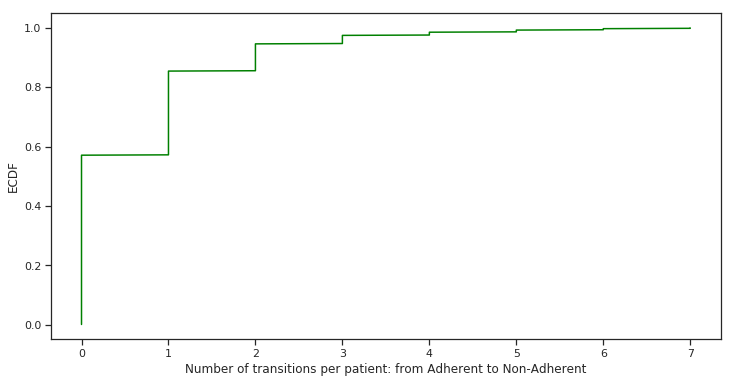

In [72]:
from statsmodels.distributions.empirical_distribution import ECDF

sns.set(style = "ticks")# to format into seaborn 
plt.figure(figsize = (12, 6))

cdf = ECDF(neg_transition_count['count'])
plt.plot(cdf.x, cdf.y, color='green');
plt.xlabel('Number of transitions per patient: from Adherent to Non-Adherent'); plt.ylabel('ECDF');

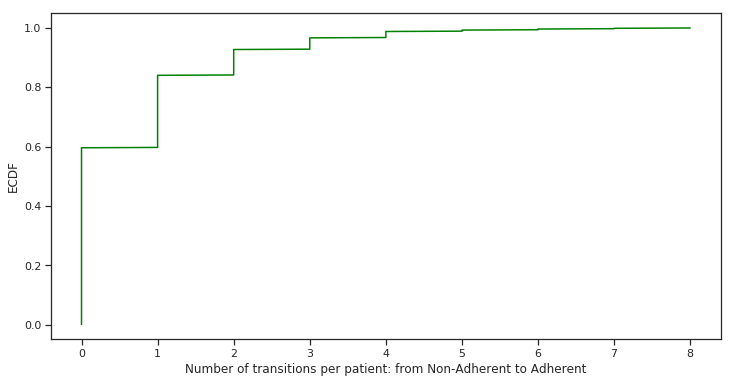

In [73]:
plt.figure(figsize = (12, 6))

cdf = ECDF(pos_transition_count['count'])
plt.plot(cdf.x, cdf.y, color='green');
plt.xlabel('Number of transitions per patient: from Non-Adherent to Adherent'); plt.ylabel('ECDF');

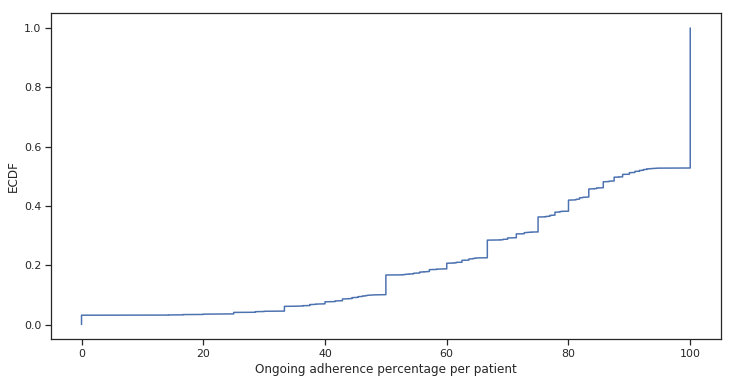

In [74]:
plt.figure(figsize = (12, 6))

cdf = ECDF(adherence_change_analysis['ongoing_adherence_percentage'])
plt.plot(cdf.x, cdf.y);
plt.xlabel('Ongoing adherence percentage per patient'); plt.ylabel('ECDF');